# Housing Insecurity Project: Exploring Factors Causing High Eviction Rates

Written by Laura Prichard, 2 December 2021

**Objectives**

- Use data on housing loss to find factors that can reduce housing insecurity. 
- Explore factors affecting eviction rates using unsupervised machine learning (ML) clustering and dimensionality reduction methods.
- Use results to see if predicting areas with higher than average eviction rates with supervised ML are improved with initial exploration using unsupervised ML.
- Model can be used to easily identify areas that may have higher than average eviction rates so additional resources can be allocated to reduce housing loss.

**Data Used**

- From the [DataKind Data Dive](https://datadive.datakind.org/), Housing Insecurity Project, 18 September 2021
- [**Housing Insecurity Project**](https://docs.google.com/document/d/1ovSvMK39wO6NXqCrH0chQL7aRHR6Lr0vQIzXhmUEBFk/edit) | [Project GitHub](https://github.com/datakind/sep21-housing-insecurity) | [Tasks](https://docs.google.com/spreadsheets/d/1H4KZ31jKkhyBYXAlYm_Bw-RjTNkVoeskye0GwtbPuvM/edit?pli=1#gid=0) | [Data Folder](https://drive.google.com/drive/folders/19B0xzeRyozYJDxwXKlGIPFe3Qnc3nfux)
- Previously performed Exploratory Data Analysis on the National Housing Preservation Database (NHPD)
- Some data cleaning to homogenize column formats and variables, already complete. Code from others to combine data from different sources. Combined in [HousingInsecurity_RentPredictionModel.ipynb](https://github.com/lprichard/machine_learning/blob/main/HousingInsecurity_RentPredictionModel.ipynb).
- Previous modeling and analysis on eviction rates with supervised ML in [HousingInsecurity_EvictionRateModel.ipynb](https://github.com/lprichard/machine_learning/blob/main/HousingInsecurity_EvictionRateModel.ipynb).

**Skills**
- Data Cleaning
- Exploratory Data Analysis
- Feature Engineering
- Testing of Feature Importance
- Predictive Modeling
- Hyperparameter Tuning
- Unsupervised Methods
    - K-Means Clustering
    - Agglomerative Clustering
    - Principal Component Analysis
- Supervised Models
    - Random Forest Classifier
    - Linear Regression
    - Logistic Regression
- Cross Validation

**Overview**

This investigation aimed to predict areas with higher than average eviction rates in social housing based on demographic information of the areas. The primary objective of the project was to test different unsupervised machine learning models to see if they improved supervised machine learning model predictions for higher than average eviction rates. This prediction model could be used to identify areas where the eviction rate has historically been shown to be higher than average so that additional policy and resources can be put in place to prevent housing loss.

Starting from a combination of large data sets, the NHPD and ACS, the data were combined, aggregated by census-tract data and cleaned ready for analysis. Using data exploration, the 20 most useful and important features were selected for predicting the target variable (`'avg-eviction-rate'`). The target variable was transformed to a binary value of above average eviction rates to be used for classification.

Four unsupervised ML models were tested:
- MODEL 1: K-Means Clustering (n=2)
- MODEL 2: K-Means Clustering (hyperparameter tuning, n=7)
- MODEL 3: Agglomerative Clustering (n=2)
- MODEL 4: Principal Component Analysis (PCA)

The different clustering methods were cross validated by being fed into a Random Forest supervised ML classification model and measuring the ROC-AUC score of predicting the target variable. The PCA model was used for further exploration and tested with accuracy of a Logistic Regression classifier. Model 1 returned the highest ROC-AUC score when included in supervised ML predictions: 0.868 and was deemed the best fitting model and easy to interpret and apply to the data for other users. 

Unsupervised ML helped improve the supervised ML classification problem by exploring clusters within the data and adding this as a variable for prediction. Many features in the database have no correlation to the average eviction rate. Work was done to identify the best features for prediction with some correlation with the target variable. These features are likely to have root underlying causes. Ultimately areas with these demographics should be targeted for the most housing assistance to prevent evictions. 


**Conclusions**

**Recommending MODEL 1: K-Means Clustering (n=2)** for finding clusters in the data and improving prediction of areas with higher than average eviction rates.  

**Next Steps**

- ROC-AUC score of 0.868 is reasonable given the stochastic nature of the real-world data. Perhaps there are features not included in the database that could have better correlation with the target variable, such as poverty rates. 
- Using more unsupervised ML techniques could be valuable to exploring different and interesting features in the data.
- This analysis is based on only three counties worth of data in Florida. Expanding this analysis to more counties would be interesting to see how the relation between these predictive metrics and the target variables varies by area across the US.

In [1]:
import os
import copy
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score, mean_squared_error

pd.options.display.max_rows = 100

# Load data

In [2]:
# Set data directory
data_root = "/Users/lprichard/Dropbox/Data_Science/DataKind_18Sep21/"
os.chdir(data_root)

# Load in data
df = pd.read_csv('./data/nhpd_loss_censustract_clean_florida.csv')
display(df.head())
display(df.info())
df.columns.to_list()

CensusTract        County  CountyCode  ActiveSubsidies  \
0  1.205700e+10  Hillsborough     12057.0                8   
1  1.205700e+10  Hillsborough     12057.0                4   
2  1.205700e+10  Hillsborough     12057.0                1   
3  1.205700e+10  Hillsborough     12057.0                1   
4  1.205700e+10  Hillsborough     12057.0                1   

   TotalInconclusiveSubsidies  TotalInactiveSubsidies  TotalUnits  \
0                           0                       1        55.0   
1                           0                       3        85.0   
2                           0                       0        84.0   
3                           0                       0         2.0   
4                           0                       0        96.0   

   NumberActiveSection8  NumberInconclusiveSection8  NumberInactiveSection8  \
0                     4                           0                       0   
1                     2                           0                       0   
2                     0                           0                       0   
3                     0                           0                       0   
4                     0                           0                       0   

   ...  avg-foreclosure-rate  foreclosure-rate-2017  foreclosure-rate-2018  \
0  ...              0.925926               1.923077               0.213675   
1  ...              1.374570               1.030928               1.030928   
2  ...              1.400000               1.800000               1.800000   
3  ...              2.020202               2.020202               1.851852   
4  ...              1.149425               1.149425               1.149425   

   foreclosure-rate-2019  avg-eviction-rate  ratio-to-mean-foreclosure-rate  \
0               0.641026           2.860353                        1.311987   
1               2.061856           3.600563                        1.947692   
2               0.600000           4.615454                        1.983724   
3               2.188552           3.730073                        2.862517   
4               1.149425           5.487367                        1.628673   

   ratio-to-mean-eviction-rate  avg-housing-loss-rate  \
0                     1.262704               2.448286   
1                     1.589470               3.444325   
2                     2.037495               3.711221   
3                     1.646643               3.314329   
4                     2.422401               3.914863   

   evictions-pct-total-housing-loss  housing-loss-index  
0                          0.919438            1.613917  
1                          0.971989            2.270508  
2                          0.893916            2.446447  
3                          0.851795            2.184815  
4                          0.893568            2.580689  

[5 rows x 90 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 90 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CensusTract                               326 non-null    float64
 1   County                                    326 non-null    object 
 2   CountyCode                                326 non-null    float64
 3   ActiveSubsidies                           326 non-null    int64  
 4   TotalInconclusiveSubsidies                326 non-null    int64  
 5   TotalInactiveSubsidies                    326 non-null    int64  
 6   TotalUnits                                326 non-null    float64
 7   NumberActiveSection8                      326 non-null    int64  
 8   NumberInconclusiveSection8                326 non-null    int64  
 9   NumberInactiveSection8                    326 non-null    int64  
 10  NumberActiveSection202                

None

['CensusTract',
 'County',
 'CountyCode',
 'ActiveSubsidies',
 'TotalInconclusiveSubsidies',
 'TotalInactiveSubsidies',
 'TotalUnits',
 'NumberActiveSection8',
 'NumberInconclusiveSection8',
 'NumberInactiveSection8',
 'NumberActiveSection202',
 'NumberActiveHUDInsured',
 'NumberInconclusiveHUDInsured',
 'NumberInactiveHud',
 'NumberActiveLihtc',
 'NumberInconclusiveLihtc',
 'NumberInactiveLihtc',
 'NumberActiveSection515',
 'NumberInactiveSection515',
 'NumberActiveSection538',
 'NumberActiveHome',
 'NumberInconclusiveHome',
 'NumberInactiveHome',
 'NumberActivePublicHousing',
 'NumberInactivePublicHousing',
 'NumberActiveState',
 'NumberInactiveState',
 'NumberActivePBV',
 'NumberActiveMR',
 'FairMarketRent_2BR',
 'total-households',
 'total-renter-occupied-households',
 'total-owner-occupied-households',
 'total-owner-occupied-households-mortgage',
 'median-gross-rent',
 'median-household-income',
 'median-property-value',
 'median-monthly-housing-cost',
 'pct-white',
 'pct-af-am',


# Exploratory data analysis, testing feature importance

In [3]:
# Getting numeric columns
data = copy.deepcopy(df)
mask1 = data.dtypes == np.float
mask2 = data.dtypes == np.int
mask = mask1 | mask2
num_cols = data.columns[mask]

In [4]:
# Check null entries
data[num_cols].info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 89 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CensusTract                               326 non-null    float64
 1   CountyCode                                326 non-null    float64
 2   ActiveSubsidies                           326 non-null    int64  
 3   TotalInconclusiveSubsidies                326 non-null    int64  
 4   TotalInactiveSubsidies                    326 non-null    int64  
 5   TotalUnits                                326 non-null    float64
 6   NumberActiveSection8                      326 non-null    int64  
 7   NumberInconclusiveSection8                326 non-null    int64  
 8   NumberInactiveSection8                    326 non-null    int64  
 9   NumberActiveSection202                    326 non-null    int64  
 10  NumberActiveHUDInsured                

In [5]:
# Remove non ID numeric columns
rem_cols = ['CensusTract', 'CountyCode'] 
an_cols = num_cols.drop(rem_cols)

# Print number of columns & names
print(len(an_cols))
an_cols

87


Index(['ActiveSubsidies', 'TotalInconclusiveSubsidies',
       'TotalInactiveSubsidies', 'TotalUnits', 'NumberActiveSection8',
       'NumberInconclusiveSection8', 'NumberInactiveSection8',
       'NumberActiveSection202', 'NumberActiveHUDInsured',
       'NumberInconclusiveHUDInsured', 'NumberInactiveHud',
       'NumberActiveLihtc', 'NumberInconclusiveLihtc', 'NumberInactiveLihtc',
       'NumberActiveSection515', 'NumberInactiveSection515',
       'NumberActiveSection538', 'NumberActiveHome', 'NumberInconclusiveHome',
       'NumberInactiveHome', 'NumberActivePublicHousing',
       'NumberInactivePublicHousing', 'NumberActiveState',
       'NumberInactiveState', 'NumberActivePBV', 'NumberActiveMR',
       'FairMarketRent_2BR', 'total-households',
       'total-renter-occupied-households', 'total-owner-occupied-households',
       'total-owner-occupied-households-mortgage', 'median-gross-rent',
       'median-household-income', 'median-property-value',
       'median-monthly-housing-

In [6]:
# Test cols to select the best for analysis, strip out uninformative/degenerate columns
tcols = ['ActiveSubsidies',
         'FairMarketRent_2BR',
#          'NumberActiveHUDInsured',
#          'NumberActiveHome',
#          'NumberActiveLihtc',
#          'NumberActivePublicHousing',
#          'NumberActiveSection515',
#          'NumberActiveSection8',
#          'NumberActiveState',
#          'NumberInactiveHud',
#          'NumberInactiveLihtc',
#          'NumberInactivePublicHousing',
#          'NumberInactiveSection515',
#          'NumberInconclusiveHUDInsured',
#          'NumberInconclusiveLihtc',
#          'NumberInconclusiveSection8',
         'TotalInactiveSubsidies',
#          'TotalInconclusiveSubsidies',
#          'avg-eviction-rate',            #This will be the target variable, defined further down
#          'avg-evictions',
#          'avg-foreclosure-rate',
#          'avg-foreclosure-sales',
#          'avg-housing-loss-rate',
         'drive-to-work',
         'english-fluency',
#          'eviction-filings-2017',
#          'eviction-filings-2018',
#          'eviction-filings-2019',
#          'eviction-rate-2017',
#          'eviction-rate-2018',
#          'evictions-pct-total-housing-loss',
#          'foreclosure-rate-2017',
#          'foreclosure-rate-2018',
#          'foreclosure-rate-2019',
#          'foreclosure-sales-2017',
#          'foreclosure-sales-2018',
#          'foreclosure-sales-2019',
         'households-children',
         'immigrant-status',
         'level-of-education',
         'median-gross-rent',
         'median-house-age',
         'median-household-income',
         'median-monthly-housing-cost',
         'median-property-value',
         'older-adult-alone',
         'pct-af-am',
         'pct-asian',
         'pct-hispanic',
         'pct-multiple',
         'pct-non-white',
         'pct-other',
         'pct-owner-occupied',
#          'pct-owner-occupied-mortgage',
#          'pct-owner-occupied-without-mortgage',
         'pct-renter-occupied',
         'pct-white',
         'pct-without-health-insurance',
         'public-transport-to-work',
#          'ratio-to-mean-eviction-rate',
#          'ratio-to-mean-foreclosure-rate',
         'single-parent-household',
#          'total-evictions',
#          'total-evictions-2017',
#          'total-evictions-2018',
#          'total-evictions-2019',
#          'total-foreclosure-sales',
         'total-households',
         'total-owner-occupied-households',
#          'total-owner-occupied-households-mortgage',
         'total-renter-occupied-households',
         'vacant-properties']

data[tcols]

ActiveSubsidies  FairMarketRent_2BR  TotalInactiveSubsidies  \
0                  8              1220.0                       1   
1                  4              1070.0                       3   
2                  1              1070.0                       0   
3                  1              1070.0                       0   
4                  1              1220.0                       0   
..               ...                 ...                     ...   
321                1              1980.0                       0   
322                2              1130.0                       2   
323                1              1500.0                       0   
324               11              1160.0                       2   
325               11              1520.0                       2   

     drive-to-work  english-fluency  households-children  immigrant-status  \
0             1939             3790                  172               387   
1              958             2610                   11               184   
2             1760             3718                  169               355   
3             1874             4334                  389               508   
4             1002             1704                  132               285   
..             ...              ...                  ...               ...   
321           4965             7534                  816               800   
322            974             1584                   11               126   
323            890             1869                   77               228   
324           1062             4093                  172               200   
325           2981             5190                  118               677   

     level-of-education  median-gross-rent  median-house-age  ...  \
0                   275              905.0                44  ...   
1                   142              773.0                41  ...   
2                    98              983.0                51  ...   
3                   438              984.0                50  ...   
4                   222             1058.0                38  ...   
..                  ...                ...               ...  ...   
321                 340             1617.0                17  ...   
322                  82              706.0                61  ...   
323                 171              962.0                65  ...   
324                  95              385.0                46  ...   
325                 498             1250.0                19  ...   

     pct-owner-occupied  pct-renter-occupied  pct-white  \
0             30.394525            69.605475       1217   
1             11.256906            88.743094        432   
2             34.595701            65.404299        847   
3             32.714702            67.285298       1307   
4             42.750234            57.249766        499   
..                  ...                  ...        ...   
321           43.341984            56.658016       3751   
322           48.785872            51.214128        257   
323           44.029170            55.970830       1024   
324           37.016575            62.983425        532   
325           20.004844            79.995156       2809   

     pct-without-health-insurance  public-transport-to-work  \
0                       12.285892                        37   
1                       24.672489                       147   
2                       19.553259                        90   
3                       21.705804                       232   
4                       20.594480                        23   
..                            ...                       ...   
321                      9.463956                        38   
322                     19.147046                        67   
323                     11.671803                        25   
324                     15.870656                       117   
325                 

In [7]:
# Get correlation matrix of features
corr_mat = data[tcols].corr()

# Strip the diagonal for examination
for x in range(corr_mat.shape[0]):
    corr_mat.iloc[x,x] = 0.0
    
corr_mat

ActiveSubsidies  FairMarketRent_2BR  \
ActiveSubsidies                          0.000000           -0.090965   
FairMarketRent_2BR                      -0.090965            0.000000   
TotalInactiveSubsidies                   0.328846           -0.054938   
drive-to-work                            0.066954            0.029722   
english-fluency                          0.083636           -0.197800   
households-children                      0.068748            0.107248   
immigrant-status                         0.034992            0.292096   
level-of-education                      -0.001030            0.082705   
median-gross-rent                       -0.263488            0.483428   
median-house-age                         0.033989            0.005694   
median-household-income                 -0.312345            0.258177   
median-monthly-housing-cost             -0.161480            0.509491   
median-property-value                   -0.159051            0.523467   
older-adult-alone                        0.183456            0.066003   
pct-af-am                                0.247772           -0.277732   
pct-asian                               -0.005800            0.102450   
pct-hispanic                             0.179764            0.213107   
pct-multiple                             0.032781            0.023658   
pct-non-white                           -0.063088           -0.188142   
pct-other                                0.157052            0.024735   
pct-owner-occupied                      -0.392318           -0.018552   
pct-renter-occupied                      0.392318            0.018552   
pct-white                                0.063088            0.188142   
pct-without-health-insurance             0.212300           -0.013771   
public-transport-to-work                 0.358957            0.046727   
single-parent-household                  0.198785            0.089549   
total-households                         0.203063            0.039937   
total-owner-occupied-households         -0.133010            0.052635   
total-renter-occupied-households         0.427634            0.007566   
vacant-properties                        0.095369            0.316585   

                                  TotalInactiveSubsidies  drive-to-work  \
ActiveSubsidies                                 0.328846       0.066954   
FairMarketRent_2BR                             -0.054938       0.029722   
TotalInactiveSubsidies                          0.000000      -0.051392   
drive-to-work                                  -0.051392       0.000000   
english-fluency                                 0.065313       0.659863   
households-children                            -0.030533       0.852203   
immigrant-status                               -0.101630       0.558470   
level-of-education                             -0.057617       0.637511   
median-gross-rent                              -0.253176       0.327616   
median-house-age                               -0.021886      -0.036494   
median-household-income                        -0.205890       0.316735   
median-monthly-housing-cost                    -0.090797       0.050725   
median-property-value                          -0.055380       0.005083   
older-adult-alone                               0.192332       0.414488   
pct-af-am                                       0.089497       0.158578   
pct-asian                                      -0.006599       0.641457   
pct-hispanic                                   -0.007389       0.557132   
pct-multiple                                    0.041840       0.528805   
pct-non-white                                  -0.020326      -0.791237   
pct-other                                       0.095254       0.403481   
pct-owner-occupied                             -0.259533       0.226602   
pct-renter-occupied                             0.259533      -0.226602   
pct-white                                    

In [8]:
# Show most strongly correlated features
corr_mat.abs().idxmax()

ActiveSubsidies                     total-renter-occupied-households
FairMarketRent_2BR                             median-property-value
TotalInactiveSubsidies                               ActiveSubsidies
drive-to-work                                       total-households
english-fluency                                     total-households
households-children                                    drive-to-work
immigrant-status                                        pct-hispanic
level-of-education                                     drive-to-work
median-gross-rent                            median-household-income
median-house-age                         median-monthly-housing-cost
median-household-income                          pct-renter-occupied
median-monthly-housing-cost                    median-property-value
median-property-value                    median-monthly-housing-cost
older-adult-alone                   total-renter-occupied-households
pct-af-am                         

In [9]:
# Determine skew values of columns
log_columns = data[tcols].skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]

log_columns

median-house-age                    12.707901
pct-asian                            4.659005
level-of-education                   4.339416
vacant-properties                    4.058053
median-property-value                4.056503
households-children                  3.994761
total-owner-occupied-households      3.025565
total-households                     2.743396
pct-multiple                         2.591654
drive-to-work                        2.533830
pct-other                            2.331348
median-monthly-housing-cost          2.103780
english-fluency                      2.078483
pct-white                            2.072735
ActiveSubsidies                      1.951825
single-parent-household              1.951287
public-transport-to-work             1.946581
older-adult-alone                    1.940277
TotalInactiveSubsidies               1.637998
immigrant-status                     1.547484
median-household-income              1.463298
total-renter-occupied-households  

In [10]:
# Log transform columns
for col in log_columns.index:
    data[col] = np.log1p(data[col])

In [11]:
# Apply standard scalar to data
sc = StandardScaler()
data[tcols] = sc.fit_transform(data[tcols])

data[tcols].head(4)

ActiveSubsidies  FairMarketRent_2BR  TotalInactiveSubsidies  drive-to-work  \
0         1.171094           -1.017999                0.483286       0.190383   
1         0.259564           -1.805544                1.829315      -0.994588   
2        -1.161406           -1.805544               -0.862744       0.027567   
3        -1.161406           -1.805544               -0.862744       0.133066   

   english-fluency  households-children  immigrant-status  level-of-education  \
0         0.807735            -0.234592         -0.634453           -0.191406   
1         0.396616            -3.059864         -1.409334           -1.104784   
2         0.786595            -0.253114         -0.724506           -1.615572   
3         0.955572             0.626054         -0.350465            0.453250   

   median-gross-rent  median-house-age  ...  pct-owner-occupied  \
0          -0.859819         -0.007265  ...           -0.587593   
1          -1.355641         -0.058275  ...           -1.537179   
2          -0.566833          0.099630  ...           -0.379136   
3          -0.563077          0.085273  ...           -0.472469   

   pct-renter-occupied  pct-white  pct-without-health-insurance  \
0             0.587593   0.255382                     -0.809962   
1             1.537179  -1.007377                      0.873450   
2             0.379136  -0.186712                      0.177716   
3             0.472469   0.342424                      0.470260   

   public-transport-to-work  single-parent-household  total-households  \
0                 -0.184317                 0.255643          0.739651   
1                  0.613458                 0.437446         -0.526483   
2                  0.328086                -0.102066          0.176574   
3                  0.879746                 0.822118          0.976646   

   total-owner-occupied-households  total-renter-occupied-households  \
0                         0.183813                          0.942786   
1                        -1.879005                          0.460084   
2                         0.034829                          0.451201   
3                         0.419165                          1.051935   

   vacant-properties  
0          -0.597631  
1           0.326291  
2          -0.150308  
3          -0.554377  

[4 rows x 30 columns]

In [12]:
# Test which features correlate most with the target: avg-eviction-rate
y = data['avg-eviction-rate']
correlations = data[tcols].corrwith(y)
correlations.sort_values(inplace=True)
correlations

pct-white                          -0.417361
median-property-value              -0.412904
pct-hispanic                       -0.345063
FairMarketRent_2BR                 -0.324321
median-monthly-housing-cost        -0.314633
immigrant-status                   -0.305823
median-gross-rent                  -0.219889
median-household-income            -0.165314
households-children                -0.155067
older-adult-alone                  -0.141898
total-households                   -0.116448
drive-to-work                      -0.115487
total-owner-occupied-households    -0.113827
level-of-education                 -0.095851
single-parent-household            -0.071143
total-renter-occupied-households   -0.058479
pct-owner-occupied                 -0.039181
pct-asian                          -0.022265
median-house-age                   -0.021127
ActiveSubsidies                     0.017019
pct-multiple                        0.037220
pct-renter-occupied                 0.039181
TotalInact

In [13]:
# Down-select columns based on correlations
icols = [
#     'ActiveSubsidies',
 'FairMarketRent_2BR',
#  'TotalInactiveSubsidies',
 'drive-to-work',
 'english-fluency',
 'households-children',
 'immigrant-status',
 'level-of-education',
 'median-gross-rent',
#  'median-house-age',
 'median-household-income',
 'median-monthly-housing-cost',
 'median-property-value',
 'older-adult-alone',
 'pct-af-am',
#  'pct-asian',
 'pct-hispanic',
#  'pct-multiple',
 'pct-non-white',
#  'pct-other',
#  'pct-owner-occupied',
#  'pct-renter-occupied',
 'pct-white',
 'pct-without-health-insurance',
 'public-transport-to-work',
#  'single-parent-household',
 'total-households',
 'total-owner-occupied-households',
#  'total-renter-occupied-households',
 'vacant-properties']

In [14]:
# Get stats on columns
data[icols].describe()

FairMarketRent_2BR  drive-to-work  english-fluency  \
count        3.260000e+02   3.260000e+02     3.260000e+02   
mean        -1.242360e-15  -6.974653e-16    -6.756695e-16   
std          1.001537e+00   1.001537e+00     1.001537e+00   
min         -2.211661e+00  -3.573198e+00    -3.900049e+00   
25%         -5.906922e-01  -5.725906e-01    -4.575308e-01   
50%          1.011709e-01   9.725403e-02     2.229578e-01   
75%          4.232248e-01   6.037411e-01     7.041380e-01   
max          2.867097e+00   3.210539e+00     2.428416e+00   

       households-children  immigrant-status  level-of-education  \
count         3.260000e+02      3.260000e+02        3.260000e+02   
mean          4.359158e-16      4.359158e-17        6.538737e-17   
std           1.001537e+00      1.001537e+00        1.001537e+00   
min          -5.690869e+00     -2.935928e+00       -3.141598e+00   
25%          -4.418091e-01     -6.597038e-01       -6.062193e-01   
50%           9.419644e-02      1.014179e-01        1.836946e-02   
75%           6.219714e-01      8.011238e-01        6.298016e-01   
max           2.791158e+00      2.173281e+00        3.555367e+00   

       median-gross-rent  median-household-income  \
count       3.260000e+02             3.260000e+02   
mean       -3.487326e-16             2.059702e-15   
std         1.001537e+00             1.001537e+00   
min        -3.338930e+00            -2.581482e+00   
25%        -5.658943e-01            -6.552146e-01   
50%        -1.254765e-01            -3.987534e-02   
75%         4.651905e-01             6.730360e-01   
max         3.929373e+00             3.127444e+00   

       median-monthly-housing-cost  median-property-value  older-adult-alone  \
count                 3.260000e+02           3.260000e+02       3.260000e+02   
mean                 -4.086711e-16           1.394931e-15      -1.634684e-17   
std                   1.001537e+00           1.001537e+00       1.001537e+00   
min                  -2.106770e+00          -3.606861e+00      -8.200747e+00   
25%                  -6.548934e-01          -5.282382e-01      -5.251253e-01   
50%                  -1.227505e-01          -9.078276e-02       8.274175e-02   
75%                   4.888460e-01           6.204012e-01       5.893332e-01   
max                   3.534003e+00           4.296018e+00       2.391328e+00   

          pct-af-am  pct-hispanic  pct-non-white     pct-white  \
count  3.260000e+02  3.260000e+02   3.260000e+02  3.260000e+02   
mean  -3.432837e-16 -6.320779e-16  -4.359158e-17 -8.718316e-16   
std    1.001537e+00  1.001537e+00   1.001537e+00  1.001537e+00   
min   -3.486470e+00 -6.924843e+00  -7.621728e+00 -4.113980e+00   
25%   -4.773122e-01 -6.724374e-01  -4.547049e-01 -5.265375e-01   
50%    1.952053e-01  5.959006e-02   1.502233e-01  1.900080e-01   
75%    7.371913e-01  7.607315e-01   7.259441e-01  6.574345e-01   
max    1.480626e+00  2.165217e+00   1.408946e+00  2.564617e+00   

       pct-without-health-insurance  public-transport-to-work  \
count                  3.260000e+02              3.260000e+02   
mean                  -3.323858e-16             -3.705284e-16   
std                    1.001537e+00              1.001537e+00   
min                   -2.261116e+00             -2.318711e+00   
25%                   -7.520000e-01             -3.848423e-01   
50%                   -8.732276e-02              2.705364e-01   
75%                    6.049146e-01              7.176209e-01   
max                    3.313912e+00              1.605755e+00   

       total-households  total-owner-occupied-households  vacant-properties  
count      3.260000e+02                     3.260000e+02       3.260000e+02  
mean       3.029615e-15                     1.830846e-15      -6.211800e-16  
std        1.001537e+00                     1.001537e+00       1.001537e+00  
min       -3.209603e+00                    -3.455694e+00      -3.575529e+00  
25%       -6.744366e-01                    -5.646300e-01      -5.921772e-0

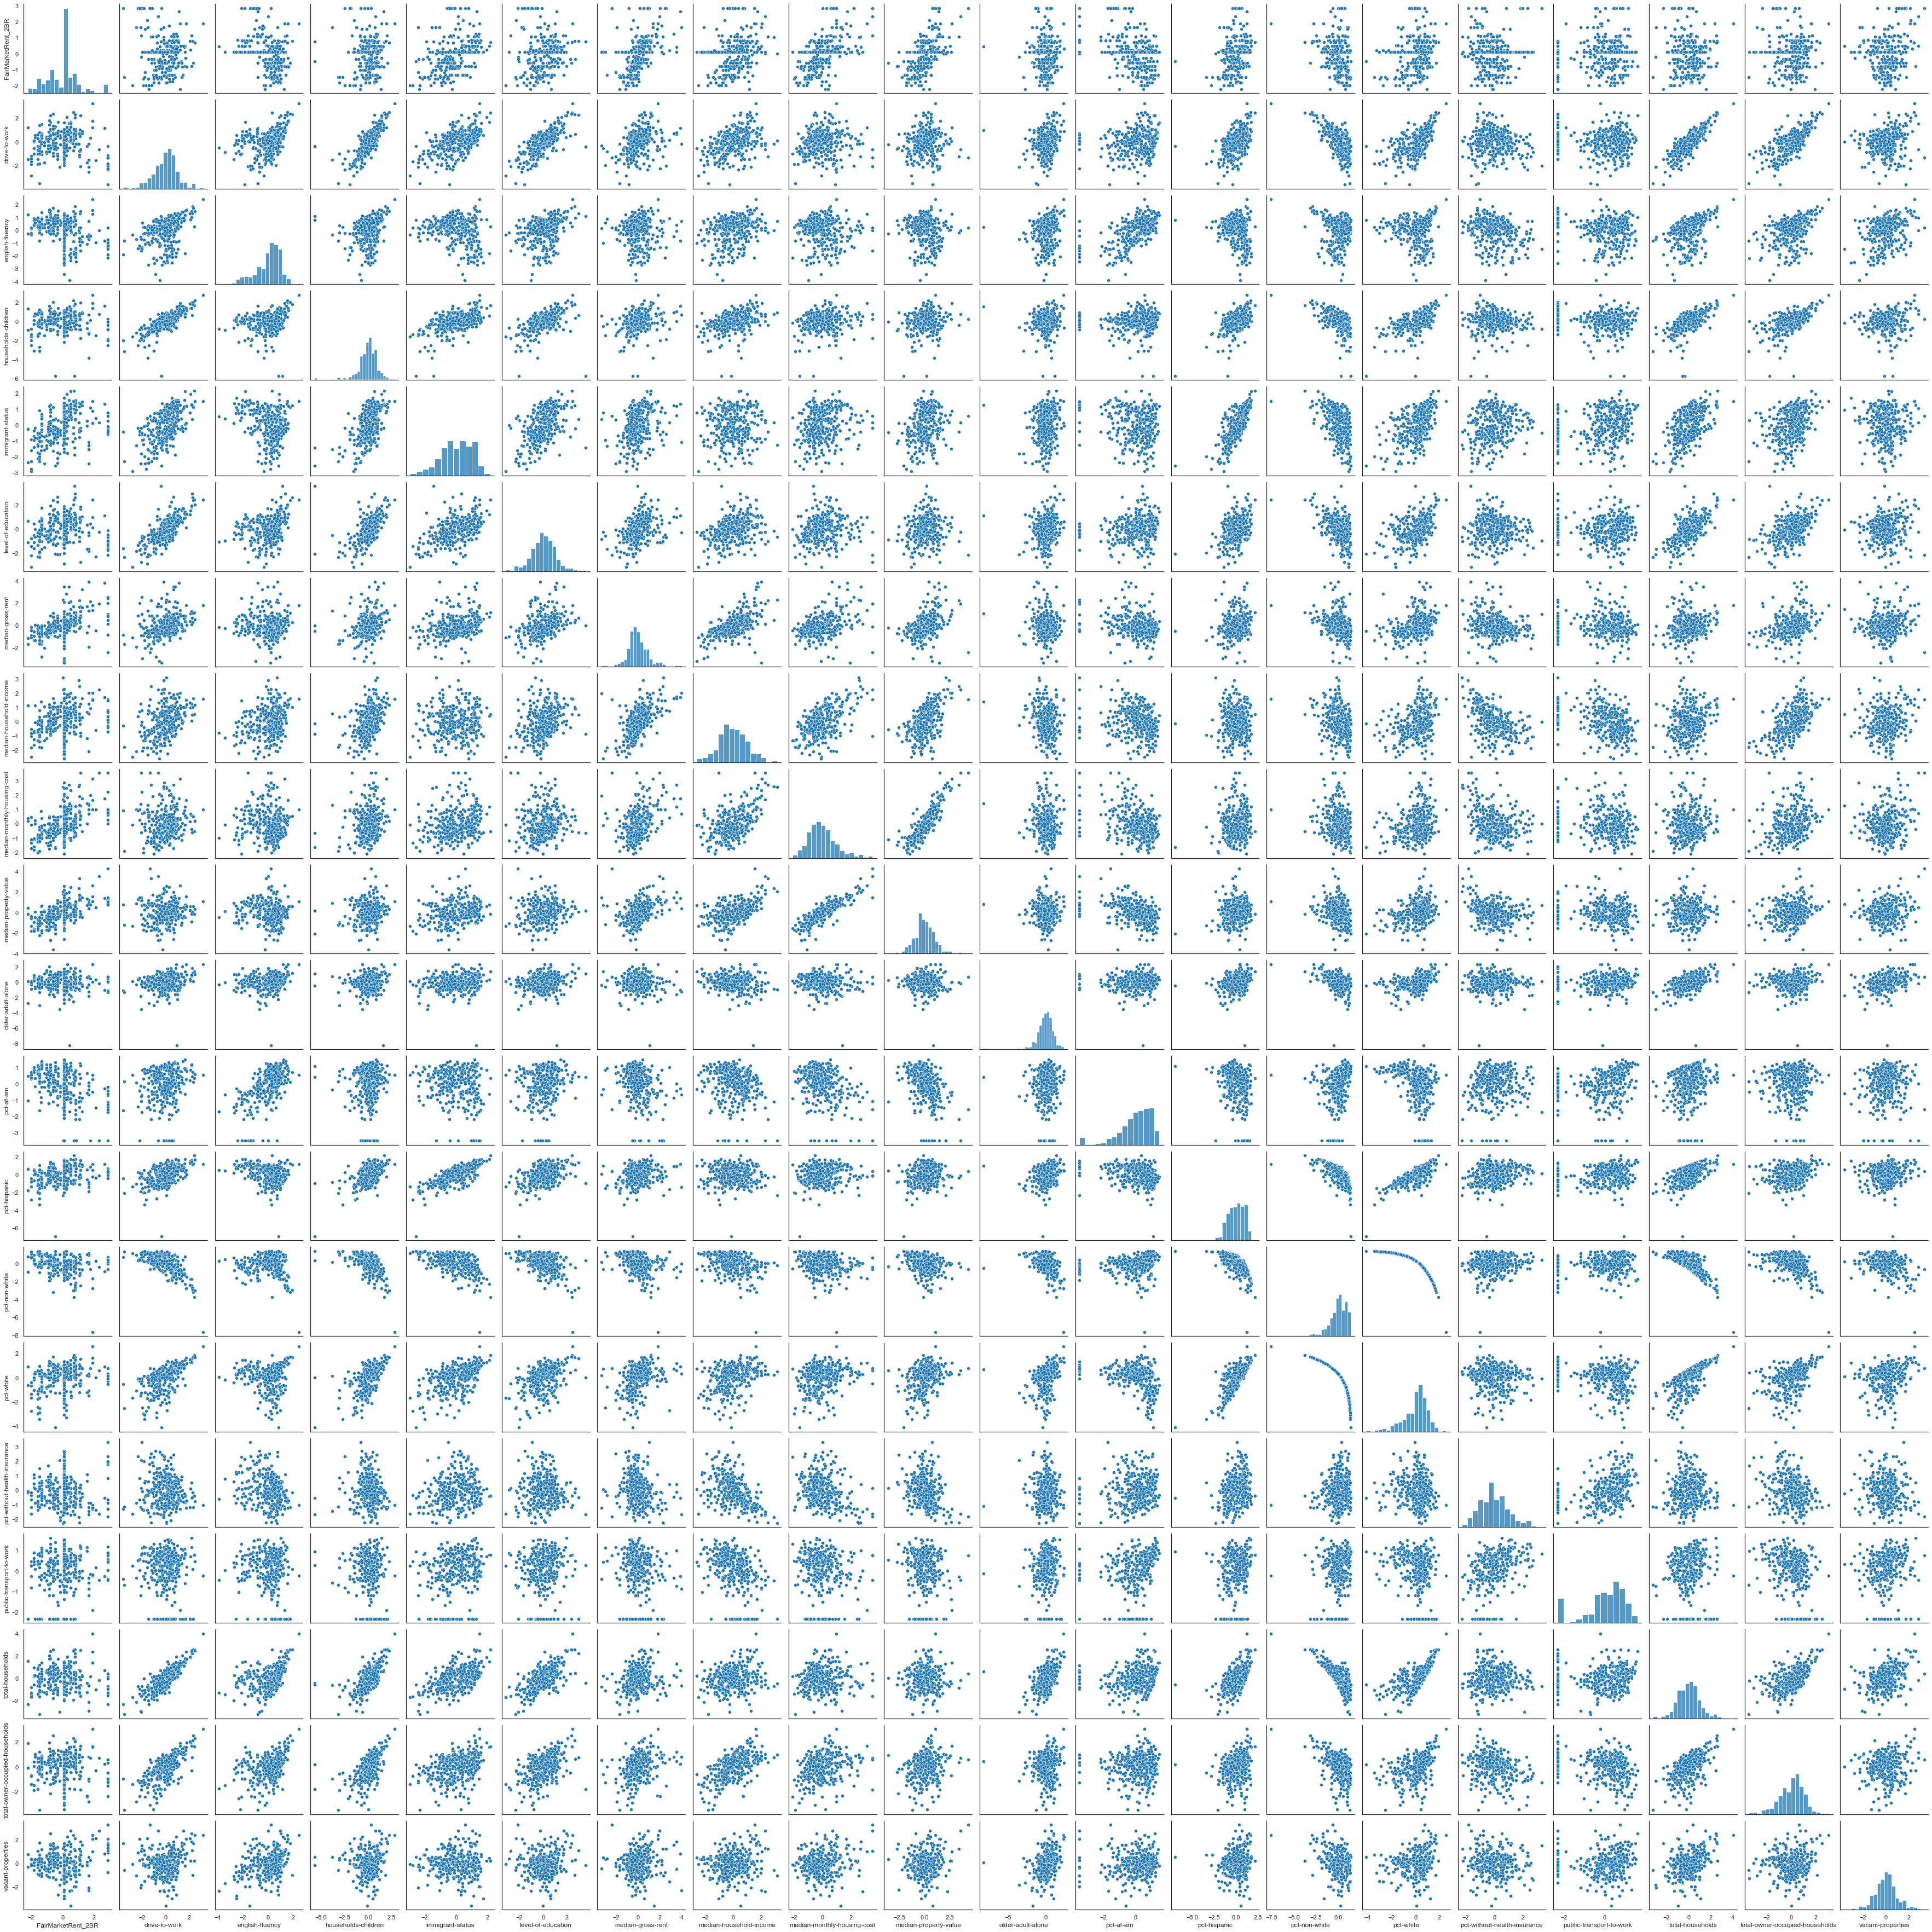

In [15]:
# Pair plot
sns.set_context('notebook')
sns.set_style('white')
sns.pairplot(data[icols]);

# Define Target Variable

In [16]:
# Define new target variable 
data['abv-avg-eviction-rate'] = (data['avg-eviction-rate'] >= data['avg-eviction-rate'].median()).astype(np.int)

In [17]:
# Get columns for analysis
cols = icols + ['avg-eviction-rate', 'abv-avg-eviction-rate']
data[cols]

FairMarketRent_2BR  drive-to-work  english-fluency  households-children  \
0             -1.017999       0.190383         0.807735            -0.234592   
1             -1.805544      -0.994588         0.396616            -3.059864   
2             -1.805544       0.027567         0.786595            -0.253114   
3             -1.805544       0.133066         0.955572             0.626054   
4             -1.017999      -0.919140        -0.073235            -0.512994   
..                  ...            ...              ...                  ...   
321            1.889582       1.771226         1.565076             1.409025   
322           -1.478038      -0.966759        -0.153696            -3.059864   
323            0.222472      -1.118285         0.028607            -1.078010   
324           -1.320745      -0.821423         0.892510            -0.234592   
325            0.302000       0.913433         1.154248            -0.630759   

     immigrant-status  level-of-education  median-gross-rent  \
0           -0.634453           -0.191406          -0.859819   
1           -1.409334           -1.104784          -1.355641   
2           -0.724506           -1.615572          -0.566833   
3           -0.350465            0.453250          -0.563077   
4           -0.953564           -0.487592          -0.285116   
..                ...                 ...                ...   
321          0.123903            0.102352           1.814616   
322         -1.802888           -1.860432          -1.607309   
323         -1.186106           -0.848296          -0.645714   
324         -1.322551           -1.658315          -2.813058   
325         -0.050516            0.631196           0.436080   

     median-household-income  median-monthly-housing-cost  \
0                  -1.172044                    -0.628824   
1                  -1.635968                    -1.611299   
2                  -0.681970                    -1.104792   
3                  -0.745478                    -1.045623   
4                  -0.346036                    -1.320325   
..                       ...                          ...   
321                 1.511975                     1.657640   
322                 0.351560                    -0.942892   
323                 0.587662                     0.326829   
324                -1.835501                     0.383123   
325                 0.491107                     1.046749   

     median-property-value  ...  pct-hispanic  pct-non-white  pct-white  \
0                -0.921468  ...     -0.130483       0.078890   0.255382   
1                -0.924859  ...     -0.640174       0.960726  -1.007377   
2                -1.586330  ...     -0.002748       0.494532  -0.186712   
3                -1.702165  ...      0.596337      -0.022212   0.342424   
4                -1.673220  ...     -1.032285       0.885461  -0.831716   
..                     ...  ...           ...            ...        ...   
321               1.561217  ...      0.508360      -2.767699   1.629067   
322              -1.023796  ...     -1.515258       1.157314  -1.639567   
323               0.648303  ...     -0.637222       0.295698   0.044744   
324               0.644192  ...     -1.198220       0.848390  -0.753679   
325               0.592560  ...      0.439685      -1.709496   1.276080   

     pct-without-health-insurance  public-transport-to-work  total-households  \
0                       -0.809962                 -0.184317          0.739651   
1                        0.873450                  0.613458         -0.526483   
2                        0.177716                  0.328086          0.176574   
3                        0.470260                  0.879746          0.976646   
4                        0.319225                 -0.453953         -1.238221   
..                            ...                       ...               ...   
321                     -1.193480                 -0.169076          2.385

# Apply K-Means Clustering to Non-Target Columns

In [18]:
# Start with 2 clusters then test params
km = KMeans(n_clusters=2, random_state=42)
km = km.fit(data[icols])

data['kmeans'] = km.predict(data[icols])

In [19]:
data[cols + ['kmeans']]

FairMarketRent_2BR  drive-to-work  english-fluency  households-children  \
0             -1.017999       0.190383         0.807735            -0.234592   
1             -1.805544      -0.994588         0.396616            -3.059864   
2             -1.805544       0.027567         0.786595            -0.253114   
3             -1.805544       0.133066         0.955572             0.626054   
4             -1.017999      -0.919140        -0.073235            -0.512994   
..                  ...            ...              ...                  ...   
321            1.889582       1.771226         1.565076             1.409025   
322           -1.478038      -0.966759        -0.153696            -3.059864   
323            0.222472      -1.118285         0.028607            -1.078010   
324           -1.320745      -0.821423         0.892510            -0.234592   
325            0.302000       0.913433         1.154248            -0.630759   

     immigrant-status  level-of-education  median-gross-rent  \
0           -0.634453           -0.191406          -0.859819   
1           -1.409334           -1.104784          -1.355641   
2           -0.724506           -1.615572          -0.566833   
3           -0.350465            0.453250          -0.563077   
4           -0.953564           -0.487592          -0.285116   
..                ...                 ...                ...   
321          0.123903            0.102352           1.814616   
322         -1.802888           -1.860432          -1.607309   
323         -1.186106           -0.848296          -0.645714   
324         -1.322551           -1.658315          -2.813058   
325         -0.050516            0.631196           0.436080   

     median-household-income  median-monthly-housing-cost  \
0                  -1.172044                    -0.628824   
1                  -1.635968                    -1.611299   
2                  -0.681970                    -1.104792   
3                  -0.745478                    -1.045623   
4                  -0.346036                    -1.320325   
..                       ...                          ...   
321                 1.511975                     1.657640   
322                 0.351560                    -0.942892   
323                 0.587662                     0.326829   
324                -1.835501                     0.383123   
325                 0.491107                     1.046749   

     median-property-value  ...  pct-non-white  pct-white  \
0                -0.921468  ...       0.078890   0.255382   
1                -0.924859  ...       0.960726  -1.007377   
2                -1.586330  ...       0.494532  -0.186712   
3                -1.702165  ...      -0.022212   0.342424   
4                -1.673220  ...       0.885461  -0.831716   
..                     ...  ...            ...        ...   
321               1.561217  ...      -2.767699   1.629067   
322              -1.023796  ...       1.157314  -1.639567   
323               0.648303  ...       0.295698   0.044744   
324               0.644192  ...       0.848390  -0.753679   
325               0.592560  ...      -1.709496   1.276080   

     pct-without-health-insurance  public-transport-to-work  total-households  \
0                       -0.809962                 -0.184317          0.739651   
1                        0.873450                  0.613458         -0.526483   
2                        0.177716                  0.328086          0.176574   
3                        0.470260                  0.879746          0.976646   
4                        0.319225                 -0.453953         -1.238221   
..                            ...                       ...               ...   
321                     -1.193480                 -0.169076          2.385496   
322                      0.122510                  0.157132         -1.626164   
323                     -0.893420                 -0.406987         -1.177586   

In [20]:
(data[['abv-avg-eviction-rate','kmeans']]
 .groupby(['kmeans','abv-avg-eviction-rate'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
kmeans abv-avg-eviction-rate        
0      0                          59
       1                         102
1      0                         104
       1                          61

**Find Optimum Cluster Number**

In [21]:
# Create and fit a range of models
km_list = list()

for clust in range(1,21):
    km = KMeans(n_clusters=clust, random_state=42)
    km = km.fit(data[icols])
    
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))

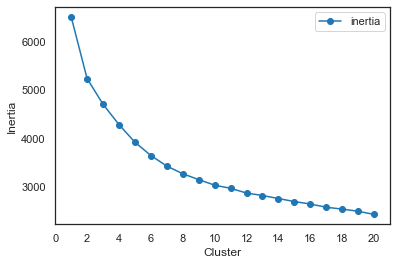

In [22]:
# Plot different intertia values for different cluster values
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,21,2))
ax.set_xlim(0,21)
ax.set(xlabel='Cluster', ylabel='Inertia');

Re-ran cells above with n=7 to test new clusters

# Apply Agglomerative Clustering

In [23]:
# Run agglomerative clustering with 2 clusters
ag = AgglomerativeClustering(n_clusters=2, linkage='ward', compute_full_tree=True)
ag = ag.fit(data[icols])
data['agglom'] = ag.fit_predict(data[icols])

In [24]:
# Compare values with target
(data[['abv-avg-eviction-rate','agglom','kmeans']]
 .groupby(['abv-avg-eviction-rate','agglom'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
abv-avg-eviction-rate agglom        
0                     0          135
                      1           28
1                     0           80
                      1           83

In [25]:
# Comparing with KMeans results
(data[['abv-avg-eviction-rate','agglom','kmeans']]
 .groupby(['abv-avg-eviction-rate','agglom', 'kmeans'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
abv-avg-eviction-rate agglom kmeans        
0                     0      0           32
                             1          103
                      1      0           27
                             1            1
1                     0      0           21
                             1           59
                      1      0           81
                             1            2

# Classification with Clustering

In [26]:
# Define x and y data with and without clustering
tmodel = 'agglom' # 'kmeans'
y = data['abv-avg-eviction-rate']
X_with_clust = data[icols + [tmodel]]
X_without_clust = data[icols]
sss = StratifiedShuffleSplit(n_splits=10, random_state=6532)

# Measure ROC-AUC values
def get_avg_roc_10splits(estimator, X, y):
    roc_auc_list = []
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        estimator.fit(X_train, y_train)
        y_predicted = estimator.predict(X_test)
        y_scored = estimator.predict_proba(X_test)[:, 1]
        roc_auc_list.append(roc_auc_score(y_test, y_scored))
    return np.mean(roc_auc_list)

# Run a random forest classifier and compare performance
estimator = RandomForestClassifier()
roc_with_clust = get_avg_roc_10splits(estimator, X_with_clust, y)
roc_without_clust = get_avg_roc_10splits(estimator, X_without_clust, y)
print("Without {} cluster as input to Random Forest, roc-auc is {:.4f}".format(tmodel, roc_without_clust))
print("Using {} cluster as input to Random Forest, roc-auc is {:.4f}".format(tmodel, roc_with_clust))

Without agglom cluster as input to Random Forest, roc-auc is 0.8507
Using agglom cluster as input to Random Forest, roc-auc is 0.8614


# Linear Regression with Clustering

In [27]:
# Define model
lr = LinearRegression()

# Define data sets
y_col = "avg-eviction-rate"
X = data[icols + ['kmeans']]
y = data[y_col]

In [28]:
# Split data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)

In [29]:
# Do a boxcox tranformation on the y data
bc_result1 = boxcox(y_train)
y_train_bc = bc_result1[0]
lam1 = bc_result1[1]
lam1

0.19611718864215705

In [30]:
# Run linear regression on transformed data
lr.fit(X_train, y_train_bc)
y_pred_bc = lr.predict(X_test)

# Determine R2 score
y_pred_tran = inv_boxcox(y_pred_bc,lam1)
r2_score(y_pred_tran,y_test)

-0.45371005670173536

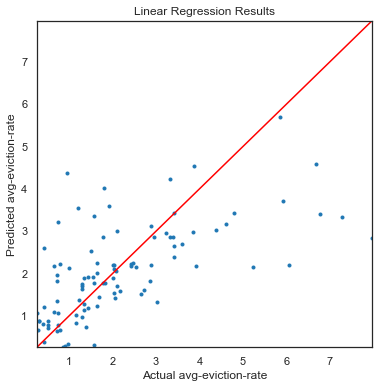

In [31]:
# Compare actual vs predicted values
f = plt.figure(figsize=(6,6))
ax = plt.axes()

# Plot the test data and predictions
ax.plot(y_test, y_pred_tran, 
         marker='o', ls='', ms=3.0)

xvals = np.linspace(y_test.min(), y_test.max(),100)
plt.plot(xvals, xvals, '-r')

lim = (y_test.min(), y_test.max())

ax.set(xlabel='Actual avg-eviction-rate', 
       ylabel='Predicted avg-eviction-rate', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results');

# Dimensionality Reduction

In [32]:
# Perform principal component analysis
pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models
for n in range(1, 10):
    
    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(data[icols])
    
    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n, 
                                             'features': data[icols].columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
pca_df

model       var
n                               
1  PCA(n_components=1)  0.331361
2  PCA(n_components=2)  0.496049
3  PCA(n_components=3)  0.631191
4  PCA(n_components=4)  0.710965
5  PCA(n_components=5)  0.782191
6  PCA(n_components=6)  0.819616
7  PCA(n_components=7)  0.852118
8  PCA(n_components=8)   0.87751
9  PCA(n_components=9)  0.899262

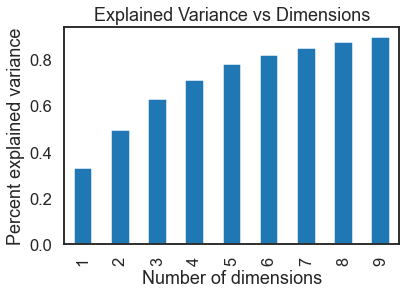

In [33]:
# Look at contributions from dimensions
sns.set_context('talk')
ax = pca_df['var'].plot(kind='bar')

ax.set(xlabel='Number of dimensions',
       ylabel='Percent explained variance',
       title='Explained Variance vs Dimensions');

# Test Classification with Reduced Dimensions

In [34]:
# Negative rmse of inverse transform
def scorer(pcamodel, X, y=None):

    try:
        X_val = X.values
    except:
        X_val = X
        
    # Calculate and inverse transform the data
    data_inv = pcamodel.fit(X_val).transform(X_val)
    data_inv = pcamodel.inverse_transform(data_inv)
    
    # Error calculation
    mse = mean_squared_error(data_inv.ravel(), X_val.ravel())
    
    # Take negative value
    return -1.0 * mse

# Grid search parameters
param_grid = {'gamma':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0],
              'n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

# Use Grid Search to tune hyperparams
kernelPCA = GridSearchCV(KernelPCA(kernel='rbf', fit_inverse_transform=True),
                         param_grid=param_grid,
                         scoring=scorer,
                         n_jobs=-1)


kernelPCA = kernelPCA.fit(data[icols])

kernelPCA.best_estimator_

KernelPCA(fit_inverse_transform=True, gamma=0.1, kernel='rbf', n_components=10)

In [35]:
# Measure scores on different numbers of components
X = data[icols]
y = data['abv-avg-eviction-rate']
sss = StratifiedShuffleSplit(n_splits=5, random_state=42)

def get_avg_score(n):
    pipe = [
        ('pca', PCA(n_components=n)),
        ('estimator', LogisticRegression(solver='liblinear'))
    ]
    pipe = Pipeline(pipe)
    scores = []
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        pipe.fit(X_train, y_train)
        scores.append(accuracy_score(y_test, pipe.predict(X_test)))
    return np.mean(scores)

ns = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
score_list = [get_avg_score(n) for n in ns]

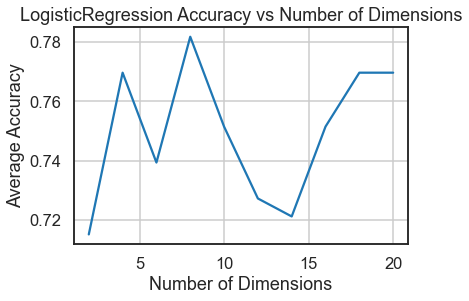

In [36]:
sns.set_context('talk')

ax = plt.axes()
ax.plot(ns, score_list)
ax.set(xlabel='Number of Dimensions',
       ylabel='Average Accuracy',
       title='LogisticRegression Accuracy vs Number of Dimensions')
ax.grid(True)